In [26]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf

import numpy as np
import pulse2percept as p2p 
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.implants import ArgusII
from pulse2percept.stimuli import BiphasicPulseTrain
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [27]:
model = BiphasicAxonMapModel(engine='cython', min_ax_sensitivity=1e-2, a4=0, xystep = 0.4)
model.build()
bundles = model.grow_axon_bundles()
axons = model.find_closest_axon(bundles)
axon_contrib = model.calc_axon_sensitivity(axons, pad=True).astype(np.float32)
implant = ArgusII()
x = np.array([implant.earray[e].x for e in implant.electrodes], dtype='float32')
y = np.array([implant.earray[e].y for e in implant.electrodes], dtype='float32')
rho=model.rho

In [28]:
def predict_freq_amp(amp, freq):
    """ Eq 4 in paper, A_2*A_tilde + A_3*f + A_4 """
    return 0.1492147*amp + 0.0163851*freq

def bright(freq, amp, pdur):
    """
    Main function to be called by BiphasicAxonMapModel
    Outputs value by which brightness contribution for each electrode should
    be scaled by (F_bright).
    Must support batching (freq, amp, pdur may be arrays)
    """
    # Scale amp according to pdur (Eq 3 in paper) and then calculate F_{bright}
    F_bright = predict_freq_amp(amp * scale_threshold(pdur), freq)
    return F_bright

def scale_threshold(pdur):
    """ 
    Based on eq 3 in paper, this function produces the factor that amplitude
    will be scaled by to produce a_tilde. Computes A_0 * t + A_1 (1/threshold)
    """
    return 0.054326 + 2.095*pdur

def size(freq, amp, pdur):
    """
    Main function to be called by BiphasicAxonMapModel
    Outputs value for each electrode that rho should be scaled by (F_size)
    Must support batching (freq, amp, pdur may be arrays)
    """
    min_f_size = 10**2 / 200**2
    F_size = 1.0812 * amp * scale_threshold(pdur) -0.35338
    return tf.maximum(F_size, min_f_size)

def streak( freq, amp, pdur):
    """
    Main function to be called by BiphasicAxonMapModel
    Outputs value for each electrode that lambda should be scaled by (F_streak)
    Must support batching (freq, amp, pdur may be arrays)
    """
    min_f_streak = 10**2 / 800 ** 2
    F_streak = 1.56 - 0.54 * pdur ** 0.21
    return tf.maximum(F_streak, min_f_streak)

In [29]:
@tf.function
def biphasic_axon_map_batched(elec_params, x, y, axon_segments, rho):
    bright_effects = bright(elec_params[:, :, 0], 
                                      elec_params[:, :, 1], 
                                      elec_params[:, :, 2])
    size_effects = size(elec_params[:, :, 0], 
                                  elec_params[:, :, 1], 
                                  elec_params[:, :, 2])
    streak_effects = streak(elec_params[:, :, 0], 
                                      elec_params[:, :, 1], 
                                      elec_params[:, :, 2])
    eparams = tf.stack([bright_effects, size_effects, streak_effects], axis=2)
    # print(eparams)

    d2_el = (axon_segments[:, :, 0, None] - x)**2 + (axon_segments[:, :, 1, None] - y)**2
    intensities = eparams[:, None, None, :, 0] * tf.math.exp(-d2_el[None, :, :, :] / (2. * rho**2 * eparams[:, :, 1])[:, None, None, :]) * (axon_segments[None, :, :, 2, None] ** (1./eparams[:, None, None, :, 2]))
    # return intensities
    return tf.reduce_max(tf.reduce_sum(intensities, axis=-1), axis=-1)

@tf.function
def biphasic_axon_map_single(elec_params, x, y, axon_segments, rho):
    bright_effects = bright(elec_params[ :, 0], 
                                      elec_params[:, 1], 
                                      elec_params[:, 2])
    size_effects = size(elec_params[:, 0], 
                                  elec_params[:, 1], 
                                  elec_params[:, 2])
    streak_effects = streak(elec_params[:, 0], 
                                      elec_params[:, 1], 
                                      elec_params[:, 2])
    eparams = tf.stack([bright_effects, size_effects, streak_effects], axis=1)

    d2_el = (axon_segments[:, :, 0, None] - x)**2 + (axon_segments[:, :, 1, None] - y)**2
    intensities = eparams[:, 0] * tf.math.exp(-d2_el / (2. * rho**2 * eparams[:, 1])) * (axon_segments[:, :, 2, None] ** (1./eparams[:, 2]))
    resp = tf.math.reduce_max(tf.math.reduce_sum(intensities, axis=-1), axis=-1)
    return resp


# def predict_one_point_tf(axon, eparams, x, y, rho):
#     d2_el = (axon[:, :, 0, None] - x)**2 + (axon[:, :, 1, None] - y)**2
#     intensities = eparams[:, 0] * tf.math.exp(-d2_el / (2. * rho**2 * eparams[:, 1])) * (axon[:, 2, None] ** (1./eparams[:, 2]))
#     return tf.math.reduce_max(tf.math.reduce_sum(intensities, axis=-1), axis=-1)

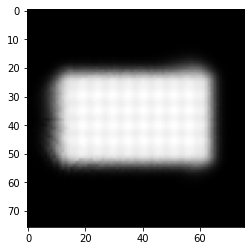

In [30]:
p = biphasic_axon_map_single(tf.ones((60, 3)), x, y, axon_contrib, rho)
p.shape
plt.imshow(np.array(p).reshape(76, 76), cmap='gray')

In [39]:
%time p = biphasic_axon_map_single(tf.ones((4, 3)), x[:4], y[:4], axon_contrib, rho)

CPU times: user 2.18 ms, sys: 7.17 ms, total: 9.35 ms
Wall time: 8.15 ms


In [40]:
%time p = biphasic_axon_map_single(tf.ones((5, 3)), x[:5], y[:5], axon_contrib, rho)

CPU times: user 70.4 ms, sys: 635 µs, total: 71 ms
Wall time: 68.8 ms


In [ ]:
a = biphasic_axon_map_batched(tf.ones((16, 15, 3)), x[:15], y[:15], axon_contrib, rho)

In [8]:
%time biphasic_axon_map_batched(tf.ones((64, 60, 3)), x, y, axon_contrib, rho)

CPU times: user 2.44 ms, sys: 1.64 ms, total: 4.07 ms
Wall time: 3.19 ms


<tf.Tensor: shape=(64, 5776), dtype=float32, numpy=
array([[8.87e-26, 1.04e-25, ..., 3.90e-15, 9.52e-16],
       [8.87e-26, 1.04e-25, ..., 3.90e-15, 9.52e-16],
       ...,
       [8.87e-26, 1.04e-25, ..., 3.90e-15, 9.52e-16],
       [8.87e-26, 1.04e-25, ..., 3.90e-15, 9.52e-16]], dtype=float32)>

<AxesSubplot:xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

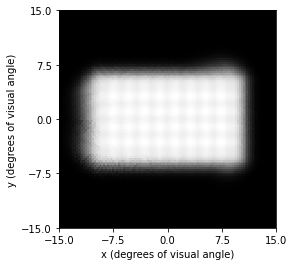

In [42]:
stim = {e : BiphasicPulseTrain(1,1,1) for e in implant.electrodes}
implant.stim = stim
p1 = model.predict_percept(implant)
p1.plot()

In [111]:
import tensorflow as tf
from keras import backend as K
import numpy as np
from skimage.transform import resize

import pulse2percept as p2p
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.stimuli import BiphasicPulseTrain
from pulse2percept.utils import center_image
from pulse2percept.implants import ArgusII


def get_loss(model, implant, regularize=None, reg_coef=0.05):
    bundles = model.grow_axon_bundles()
    axons = model.find_closest_axon(bundles)
    axon_contrib = model.calc_axon_sensitivity(axons, pad=True).astype(np.float32)
    axon_contrib = tf.constant(axon_contrib, dtype='float32')
    x = tf.constant([implant[e].x for e in implant.electrodes], dtype='float32')
    y = tf.constant([implant[e].y for e in implant.electrodes], dtype='float32')
    rho = model.rho
    # get effect models. Need to reimplement them in tensorflow fashion
    def scale_threshold(pdur):
        return model.a1 + model.a0*pdur
    def predict_freq_amp(amp, freq):
        return model.a2*amp + model.a3*freq
    def bright(freq, amp, pdur):
        F_bright = predict_freq_amp(amp * scale_threshold(pdur), freq)
        return F_bright
    def size(freq, amp, pdur):
        min_f_size = 10**2 / (model.rho**2)
        F_size = model.a5 * amp * model.scale_threshold(pdur) + model.a6
        return tf.maximum(F_size, min_f_size)
    def streak(freq, amp, pdur):
        min_f_streak = 10**2 / (model.axlambda ** 2)
        F_streak = model.a9 - model.a7 * pdur ** model.a8
        return tf.maximum(F_streak, min_f_streak)

    # def reg_none(y_pred):
    #     return tf.zeros((len(y_pred)))
    # def reg_l1(y_pred):
    #     return tf.reduce_sum(tf.abs(y_pred), axis=-1) 
    # def reg_l2(y_pred):
    #     return tf.reduce_mean(y_pred**2, axis=-1)
    # if regularize is None:
    #     reg = reg_none
    # elif regularize == 'l1':
    #     reg = reg_l1
    # elif regularize == 'l2':
    #     reg = reg_l2

    def biphasic_axon_map_batched(ypred):
        bright_effects = bright(ypred[:, :, 0], 
                                ypred[:, :, 1], 
                                ypred[:, :, 2])
        size_effects = size(ypred[:, :, 0], 
                            ypred[:, :, 1], 
                            ypred[:, :, 2])
        streak_effects = streak(ypred[:, :, 0], 
                                ypred[:, :, 1], 
                                ypred[:, :, 2])
        eparams = tf.stack([bright_effects, size_effects, streak_effects], axis=2)
        d2_el = (axon_contrib[:, :, 0, None] - x)**2 + (axon_contrib[:, :, 1, None] - y)**2
        intensities = eparams[:, None, None, :, 0] * tf.math.exp(-d2_el[None, :, :, :] / (2. * rho**2 * eparams[:, :, 1])[:, None, None, :]) * (axon_contrib[None, :, :, 2, None] ** (1./eparams[:, None, None, :, 2]))
        return tf.reduce_max(tf.reduce_sum(intensities, axis=-1), axis=-1)
    # assumes model outputs same shape as ytrue
    def mse(ytrue, ypred):
        pred_imgs = biphasic_axon_map_batched(ypred)
        yt = tf.reshape(ytrue, pred_imgs.shape)
        return tf.reduce_mean((pred_imgs - yt)**2, axis=-1)
    
    return mse

In [112]:
lossfn = get_loss(model, implant)

In [113]:
stim = np.ones((2, 60, 3), dtype='float32')
# x = np.array([implant.earray[e].x for e in implant.electrodes], dtype='float32')
# y = np.array([implant.earray[e].y for e in implant.electrodes], dtype='float32')
stim_p2p = {e : BiphasicPulseTrain(1,1,1) for e in implant.electrodes}
implant.stim = stim_p2p
perc = model.predict_percept(implant)
pdata = np.array([perc.data[:, :, 0], perc.data[:, :, 0]], dtype='float32')


In [115]:
%timeit lossfn(pdata, stim)

4.13 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
